# Import

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier
from arquitecture.SupraCardClassifier import SupraCardClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently using", DEVICE)

Currently using cuda


/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset scale testing

In [2]:
CardsDataset().data.head()

,class index,filepaths,labels,suit,category,filepaths_full
0,18,train/jack of hearts/149.jpg,jack of hearts,hearts,jack,data/train/jack of hearts/149.jpg
1,10,train/five of hearts/120.jpg,five of hearts,hearts,five,data/train/five of hearts/120.jpg
2,9,train/five of diamonds/007.jpg,five of diamonds,diamonds,five,data/train/five of diamonds/007.jpg
3,21,train/king of clubs/018.jpg,king of clubs,clubs,king,data/train/king of clubs/018.jpg
4,39,train/six of hearts/049.jpg,six of hearts,hearts,six,data/train/six of hearts/049.jpg


In [3]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

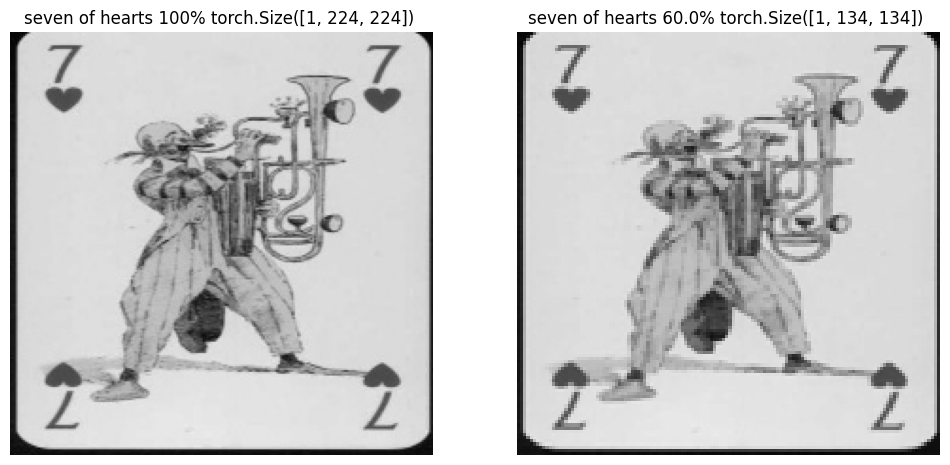

In [4]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Training process

## Hyperparameters

In [5]:
EPOCH = 100
BATCH_SIZE = 1500
NUN_WORKERS = 8
LR = 0.003
SEED = 555

In [6]:
def set_torch_seed(seed: int = 555):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_torch_seed(SEED)

In [7]:
csv_file = "cards.csv"
target = "suit"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=2,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)


print(classifier.n_parameters())

2458098


In [8]:
criterion = nn.CrossEntropyLoss(reduction = "mean")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

os.makedirs(f"models/checkpoints/", exist_ok=True)

In [9]:
def save_checkpoint(model, epoch, optimizer, loss, name):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"models/checkpoints/{name}.pth")

def validation(model, valid_loader, criterion, device):
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
                valid_loss += loss.item() * inputs.size(0)
                
                x, preds = torch.max(outputs, dim=1)
                correct += (preds == torch.argmax(labels.to(device), dim=1)).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_prec = correct / len(valid_loader.dataset)

        return valid_loss, valid_prec

In [10]:
def training(model, optimizer, criterion, train_loader, valid_loader, name, device, epochs):
    max_prec = 0
    train_loss_record = []
    valid_loss_record = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        model.eval()
        
        valid_loss, valid_prec = validation(model, valid_loader, criterion, device)
        if valid_prec > max_prec:
            save_checkpoint(model, epoch, optimizer, loss, name)
            max_prec = valid_prec
        
        train_loss_record.append(train_loss)
        valid_loss_record.append(valid_loss)
        print(f"EPOCH {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {valid_loss:.4f} - Validation Precision: {valid_prec:.4f}")
        
    return train_loss_record, valid_loss_record

EPOCH 1/100 - Training Loss: 1.5925 - Validation Loss: 1.5850 - Validation Precision: 0.2453
EPOCH 2/100 - Training Loss: 1.5833 - Validation Loss: 1.5795 - Validation Precision: 0.2453
EPOCH 3/100 - Training Loss: 1.5596 - Validation Loss: 1.5748 - Validation Precision: 0.2453
EPOCH 4/100 - Training Loss: 1.4943 - Validation Loss: 1.5889 - Validation Precision: 0.2453
EPOCH 5/100 - Training Loss: 1.3839 - Validation Loss: 1.6864 - Validation Precision: 0.2453
EPOCH 6/100 - Training Loss: 1.2375 - Validation Loss: 1.9784 - Validation Precision: 0.2453
EPOCH 7/100 - Training Loss: 1.0716 - Validation Loss: 1.4402 - Validation Precision: 0.2377
EPOCH 8/100 - Training Loss: 1.0205 - Validation Loss: 1.7790 - Validation Precision: 0.2453
EPOCH 9/100 - Training Loss: 0.9883 - Validation Loss: 1.5405 - Validation Precision: 0.2453
EPOCH 10/100 - Training Loss: 0.9841 - Validation Loss: 2.9445 - Validation Precision: 0.2415
EPOCH 11/100 - Training Loss: 0.9431 - Validation Loss: 5.7830 - Vali

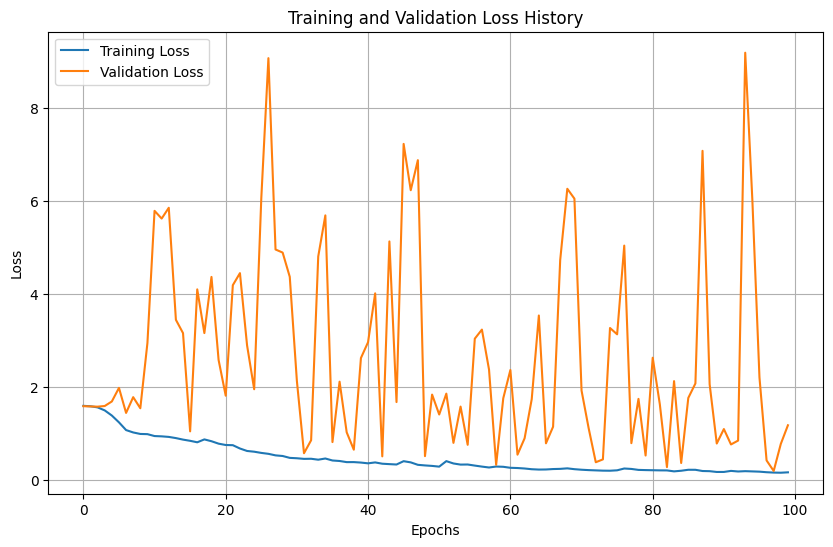

In [11]:
train_loss_record, valid_loss_record = training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="suit_classifier_checkpoint",
         device=DEVICE,
         epochs=EPOCH
         )

plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, label="Training Loss")
plt.plot(valid_loss_record, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
csv_file = "cards.csv"
target = "category"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=4,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(classifier.n_parameters())

2505907


EPOCH 1/200 - Training Loss: 2.6390 - Validation Loss: 2.6382 - Validation Precision: 0.0755
EPOCH 2/200 - Training Loss: 2.5800 - Validation Loss: 2.6356 - Validation Precision: 0.1132
EPOCH 3/200 - Training Loss: 2.5241 - Validation Loss: 2.6385 - Validation Precision: 0.0755
EPOCH 4/200 - Training Loss: 2.5136 - Validation Loss: 2.6273 - Validation Precision: 0.1019
EPOCH 5/200 - Training Loss: 2.5073 - Validation Loss: 2.5806 - Validation Precision: 0.1283
EPOCH 6/200 - Training Loss: 2.4986 - Validation Loss: 2.5875 - Validation Precision: 0.1245
EPOCH 7/200 - Training Loss: 2.4913 - Validation Loss: 2.6024 - Validation Precision: 0.1132
EPOCH 8/200 - Training Loss: 2.4612 - Validation Loss: 2.4205 - Validation Precision: 0.1547
EPOCH 9/200 - Training Loss: 2.4225 - Validation Loss: 2.4010 - Validation Precision: 0.1585
EPOCH 10/200 - Training Loss: 2.3669 - Validation Loss: 2.2963 - Validation Precision: 0.1811
EPOCH 11/200 - Training Loss: 2.3258 - Validation Loss: 2.2524 - Vali

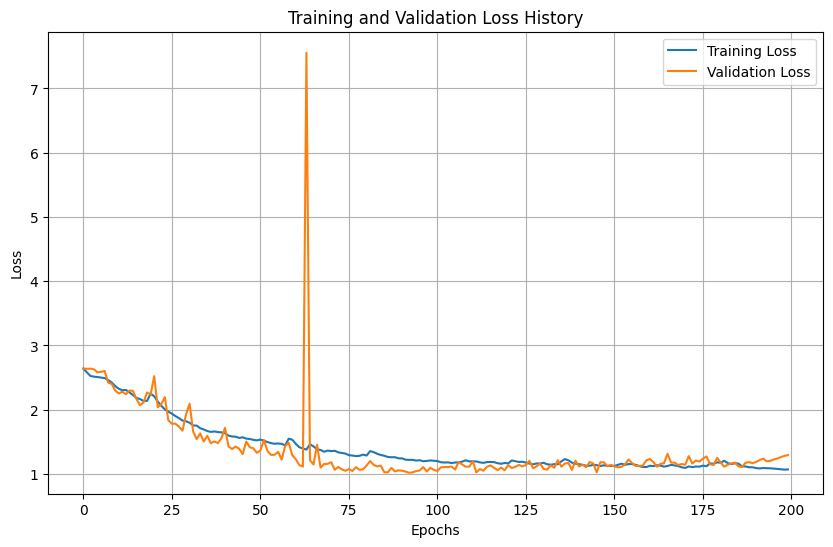

In [13]:
criterion = nn.CrossEntropyLoss(reduction = "mean")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

train_loss_record, valid_loss_record = training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="category_classifier_checkpoint",
         device=DEVICE,
         epochs=(EPOCH*2)
         )

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, label="Training Loss")
plt.plot(valid_loss_record, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.grid(True)
plt.show()